In [103]:
# AI Theme - Compact Kiwi Visualization Setup
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
warnings.filterwarnings('ignore')
AI_COLORS = {'primary':'#8FBC8F','gold':'#DAA520','crypto':'#FF6347','accent':'#6B8E23','highlight':'#ADFF2F','dark':'#2F4F2F','neutral':'#F0FFF0'}
kiwi_palette = [AI_COLORS['primary'], AI_COLORS['gold'], AI_COLORS['crypto'], AI_COLORS['accent'], AI_COLORS['highlight']]
plt.style.use('default')
sns.set_style("whitegrid")
sns.set_palette(kiwi_palette)
plt.rcParams.update({'figure.facecolor':AI_COLORS['neutral'],'figure.figsize':[12,8],'axes.facecolor':'white','axes.edgecolor':AI_COLORS['dark'],'axes.grid':True,'axes.titlecolor':AI_COLORS['dark'],'axes.titleweight':'bold','axes.titlesize':16,'axes.labelsize':12,'grid.color':AI_COLORS['primary'],'grid.alpha':0.3,'font.size':11,'xtick.color':AI_COLORS['dark'],'ytick.color':AI_COLORS['dark'],'legend.fontsize':10,'legend.frameon':True,'legend.facecolor':'white','legend.edgecolor':AI_COLORS['primary'],'lines.linewidth':2,'savefig.dpi':300,'savefig.bbox':'tight'})
sns.set_context("notebook", font_scale=1.1)

# The Problem

The problem is framed from a company, or employeer perspective. How can we predict employee retention? Who will leave and who stays? This could be in response to a decision made by the company, or to predict expenses... or plan for future layoffs. Why fire someone about to leave, save some money!

<hr>

# The Data

This is a labeled dataset of employee retention data from a real company. Provided by the companie's HR department. Publicly posted on kaggle.

Employee Retention Data: https://www.kaggle.com/datasets/tawfikelmetwally/employee-dataset

Has:
Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot

## Data explanation
Essentially it is data on the individual employee, their experience at the company, and labled if they left or not.

<hr>

# Preprocessing

First I want to import the data of course.

In [104]:
employee_df = pd.read_csv('Employee.csv')
employee_df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


I want to convert all binary columns to 0 and 1. Especially since one is already 0 1 0 1 and the other yes no yes no it will probably cause worst accuracy. I also notice Gender is binary in this data set so for accuracy we will do it to this column aswell.

In [105]:
employee_df["EverBenched"] = employee_df["EverBenched"].map({"Yes": 1, "No": 0})
employee_df["Gender"] = employee_df["Gender"].map({"Male": 0, "Female": 1})
employee_df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,0,0,0,0
1,Bachelors,2013,Pune,1,28,1,0,3,1
2,Bachelors,2014,New Delhi,3,38,1,0,2,0
3,Masters,2016,Bangalore,3,27,0,0,5,1
4,Masters,2017,Pune,3,24,0,1,2,1


Im also going to convert joining year into years at the company. this will likely be a better feature than the joining year for machine learning. This data set was posted in 2023 so I will use that as the current year.

In [106]:
employee_df["years_at_company"] = 2023 - employee_df["JoiningYear"]
employee_df.drop(columns=["JoiningYear"], inplace=True)
employee_df.head()

,Education,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot,years_at_company
0,Bachelors,Bangalore,3,34,0,0,0,0,6
1,Bachelors,Pune,1,28,1,0,3,1,10
2,Bachelors,New Delhi,3,38,1,0,2,0,9
3,Masters,Bangalore,3,27,0,0,5,1,7
4,Masters,Pune,3,24,0,1,2,1,6


while im at it to make the whole data set ill continue mapping education and city to numbers as the values seem to be limited to a few options each

In [107]:
employee_df["Education"] = employee_df["Education"].map({"Bachelors": 0, "Masters": 1, "PHD": 2})
employee_df["City"] = employee_df["City"].map({"Bangalore": 0, "Pune": 1, "New Delhi": 2})
employee_df.head()

,Education,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot,years_at_company
0,0,0,3,34,0,0,0,0,6
1,0,1,1,28,1,0,3,1,10
2,0,2,3,38,1,0,2,0,9
3,1,0,3,27,0,0,5,1,7
4,1,1,3,24,0,1,2,1,6


Hindsight is 2020. I found out that the data set is imbalanced but since I am making a copy of the data set for relabling I will include SMOT in the preprocessing section

In [108]:
print(employee_df["LeaveOrNot"].value_counts())

LeaveOrNot
0    3053
1    1600
Name: count, dtype: int64


uh oh, its imbalanced! NO ~65% did not leave and only ~35% did leave. This could create a bias and inflate accuracy while performing poorly on the minority class. Lets handle it. I looked into the best ways of handling it. I could undersample the majority class, oversample the minority class. I will oversample the yes to reach a 50/50 split. I hope that this is the wise decision because it will reinforce characteristics of leavers. I will use SMOTE aka Synthetic Minority Oversampling Technique to oversample the minority class.

I will also keep a proportional copy of the data for analysis

In [109]:
employee_df_plot_proportional = employee_df.copy()
X = employee_df.drop("LeaveOrNot", axis=1)
y = employee_df["LeaveOrNot"]
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=3)
X_res, y_res = smote.fit_resample(X, y)

employee_df = X_res.copy()
employee_df["LeaveOrNot"] = y_res

# Exploration


First thing I want to do since we will be exploring the data quite visually I want to convert the mappings back to text. Though keep the original data frame the way it is for modeling.

In [110]:
employee_df_plot = employee_df.copy()
employee_df_plot["Education"] = employee_df_plot["Education"].map({0: "Bachelors", 1: "Masters", 2: "PHD"})
employee_df_plot["City"] = employee_df_plot["City"].map({0: "Bangalore", 1: "Pune", 2: "New Delhi"})
employee_df_plot["EverBenched"] = employee_df_plot["EverBenched"].map({0: "No", 1: "Yes"})
employee_df_plot["Gender"] = employee_df_plot["Gender"].map({0: "Male", 1: "Female"})
employee_df_plot["LeaveOrNot"] = employee_df_plot["LeaveOrNot"].map({0: "No", 1: "Yes"})

employee_df_plot_proportional["Education"] = employee_df_plot_proportional["Education"].map({0: "Bachelors", 1: "Masters", 2: "PHD"})
employee_df_plot_proportional["City"] = employee_df_plot_proportional["City"].map({0: "Bangalore", 1: "Pune", 2: "New Delhi"})
employee_df_plot_proportional["EverBenched"] = employee_df_plot_proportional["EverBenched"].map({0: "No", 1: "Yes"})
employee_df_plot_proportional["Gender"] = employee_df_plot_proportional["Gender"].map({0: "Male", 1: "Female"})
employee_df_plot_proportional["LeaveOrNot"] = employee_df_plot_proportional["LeaveOrNot"].map({0: "No", 1: "Yes"})

First thing we want to explore for classification, especially since the output is binary, is the balance of the data. AKA the ratio of employees who left to those who didn't. The ratio of the target/label is an important metric to consider when building a model. If the ratio is too imbalanced, the model may not perform well.

I will oversampled the yes to reach a 50/50 split. So it should be 50% yes and 50% no.

LeaveOrNot
No     3053
Yes    3053
Name: count, dtype: int64


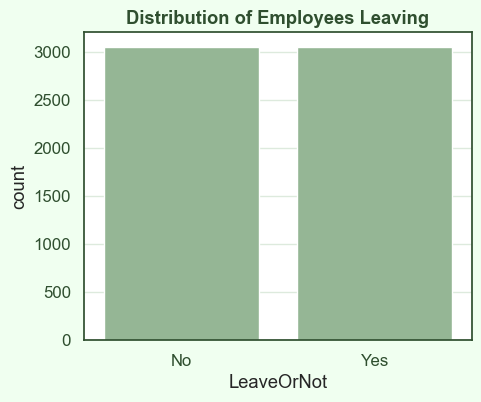

In [111]:
print(employee_df_plot["LeaveOrNot"].value_counts())
plt.figure(figsize=(5,4))
sns.countplot(x="LeaveOrNot", data=employee_df_plot)
plt.title("Distribution of Employees Leaving")
plt.show()


Awesome we now have balanced data lets check out the distribution of our target based on our features next

For this lets use our proportional copy of the data, so we can see the real chances of people leaving based on the features. It will be more intuitive to look at and we will still get a sense of the features relationship to the target

LeaveOrNot
No     3053
Yes    1600
Name: count, dtype: int64


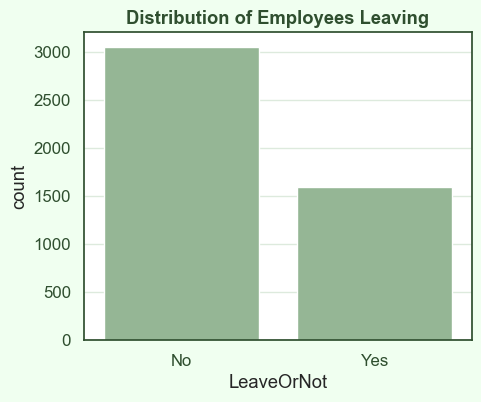

In [112]:
print(employee_df_plot_proportional["LeaveOrNot"].value_counts())
plt.figure(figsize=(5,4))
sns.countplot(x="LeaveOrNot", data=employee_df_plot_proportional)
plt.title("Distribution of Employees Leaving")
plt.show()


Lets first see our distribution based on categorical features. This will give us an idea of the patterns

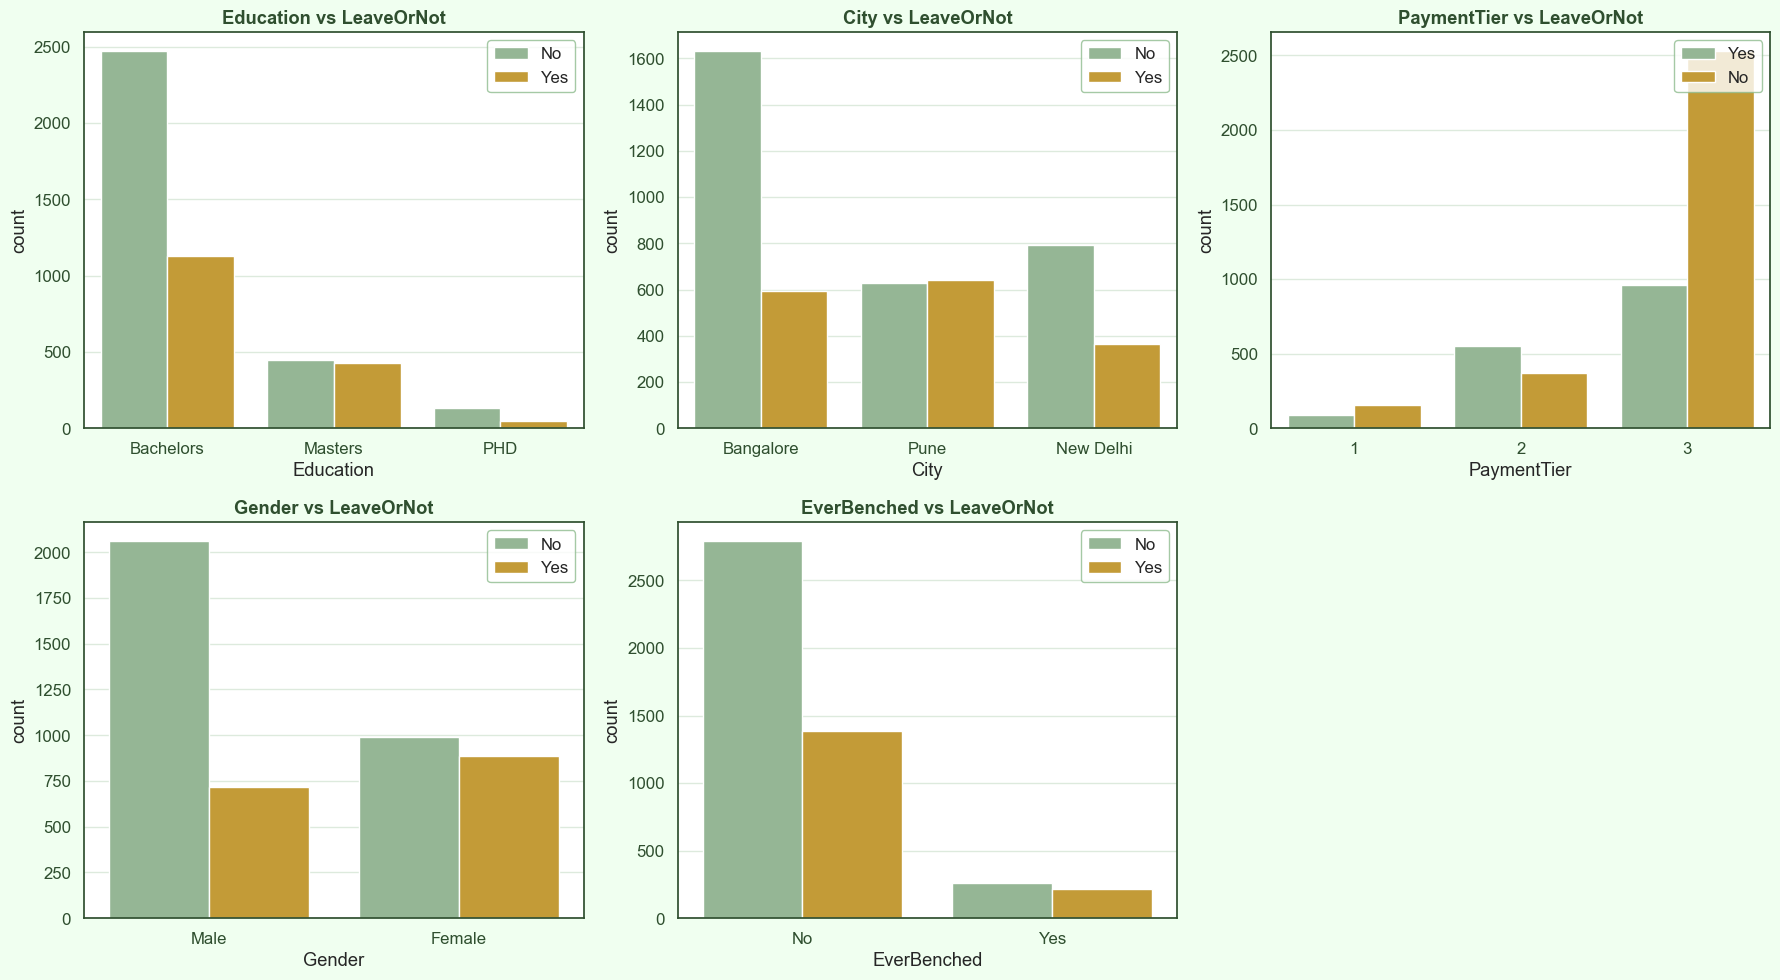

In [113]:
categorical_cols = ["Education", "City", "PaymentTier", "Gender", "EverBenched"]

# Create a single figure with multiple subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows x 3 columns
axes = axes.flatten()  # Flatten to iterate easily

for i, col in enumerate(categorical_cols):
    sns.countplot(
        x=col,
        hue="LeaveOrNot",
        data=employee_df_plot_proportional,
        ax=axes[i]
    )
    axes[i].set_title(f"{col} vs LeaveOrNot")
    axes[i].legend(loc='upper right')

# If number of subplots > number of columns, hide extra axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### findings

#### Education
Bachelors is by far the most likely to stay, phd is slightly more likely to stay. While on the other hand masters is just about a coin toss if they stay or leave!

#### City
Bangalore is by far the most likely to stay
new deli is pretty likely to stay
pune is just about a coin toss if they stay or leave!

#### PaymentTier
PaymentTier 3 is by far the most likely to stay. In fact to leave seems to be an anomaly, super interesting
paymenttier 2 is MORE likely to leave than stay. the first statistic of it's kind
paymenttier 1 is in favor of staying

#### Gender
By far females leave more often being about a coin toss if they leave or stay

#### EverBenched
unsuprisingly no seems to be about proprotional distribution to the target while yes is a 50/50

Next lets look at the numerical entries relation and distribution to the target

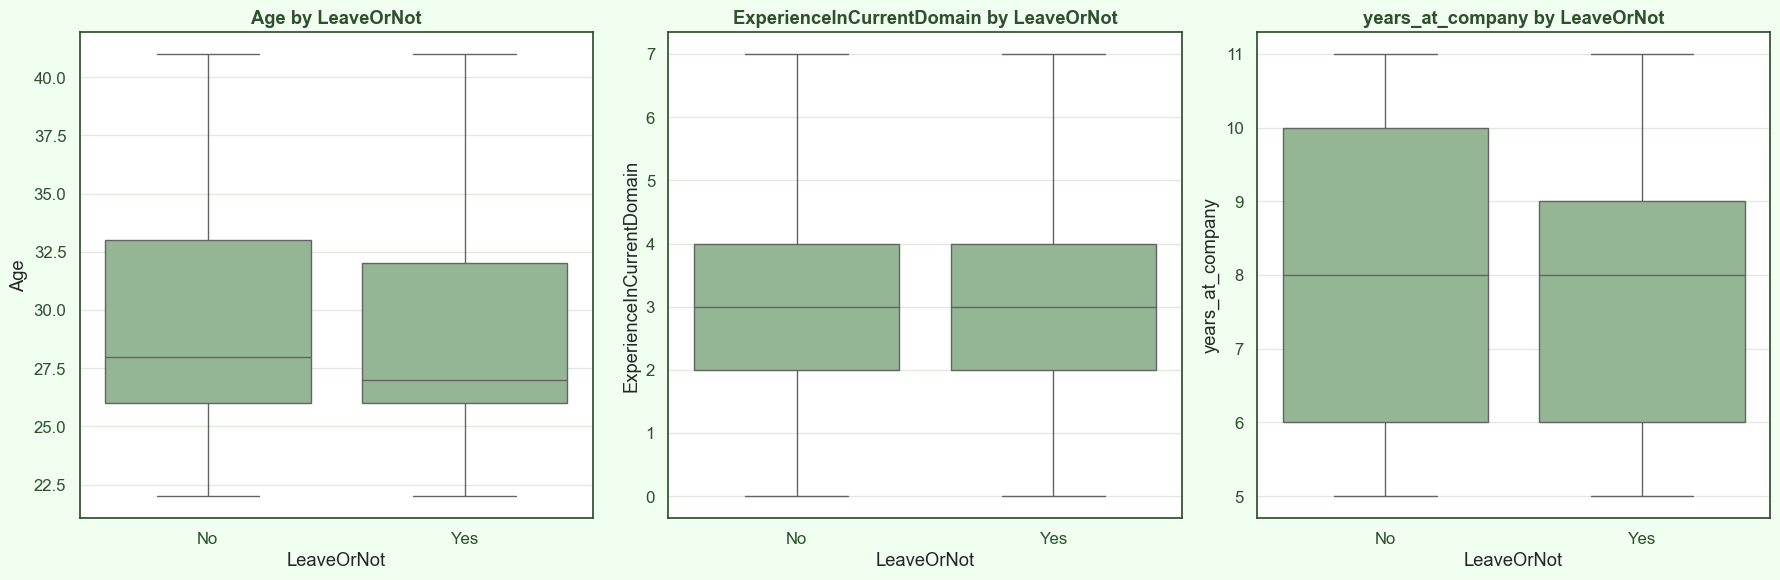

In [114]:
numerical_cols = ["Age", "ExperienceInCurrentDomain", "years_at_company"]

# Create a figure with subplots: 1 row x 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(
        x="LeaveOrNot", 
        y=col, 
        data=employee_df_plot, 
        ax=axes[i]
    )
    axes[i].set_title(f"{col} by LeaveOrNot")

plt.tight_layout()
plt.show()


### findings

#### Age
it seems around 30+ years old something changes in which people are more unlikely to leave. Maybe seniority at the company, comfortability, or stability in family life.

#### ExperienceInCurrentDomain
Seems unimportant. How suprising!

#### years_at_company
after 9 years at this company people are less likely to leave. retirement incentives? seniority, comfortability, likely the same reasons as age.

# Model

I will make a random forest model to predict employee retention. I believe it could find relationships in the features that are not immediately obvious. I also find it to be such an intuitively awesome model and I'm itching to make one.

first split in features and target

In [115]:
X = employee_df.drop('LeaveOrNot', axis=1)
y = employee_df['LeaveOrNot']

split into train and test

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Lets make a random forest mdoel, lets use 100 trees, we want pure trees so no max depth

In [117]:
rf_model = RandomForestClassifier(
    n_estimators=100,      # number of trees
    max_depth=None,        # let trees grow until pure
    random_state=42,
)

rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


lets test the mdoel

In [118]:
y_pref = rf_model.predict(X_test)
print(classification_report(y_test, y_pref))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       618
           1       0.83      0.82      0.82       604

    accuracy                           0.83      1222
   macro avg       0.83      0.83      0.83      1222
weighted avg       0.83      0.83      0.83      1222



83 f1 score is not bad!

# Story Telling


# impact

# References
## Data Sources

## Technical Assistance